In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
from operator import itemgetter

%matplotlib inline

In [2]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import DistanceMetric, NearestNeighbors
'''
from geojson import MultiPoint
from geopy.distance import great_circle
'''

'\nfrom geojson import MultiPoint\nfrom geopy.distance import great_circle\n'

In [3]:
from math import degrees, radians, sin, cos, atan2, sqrt

In [4]:
from utils import *

In [5]:
df = pd.read_csv('../../data/geohash/top_active_device_data.csv')
X = np.array(list(zip(df['lat'], df['long'])))

In [6]:
df['tz'] = df[['lat', 'long']].apply(lambda x: get_tz(x['lat'], x['long']), axis=1)
df['dt'] = df[['timestamp', 'tz']].apply(lambda x: adjust_tz(x['timestamp'], x['tz']),axis=1)
df['day'], df['month'], df['hour'], df['day_of_week'] = zip(*df['dt'].apply(get_dt_vars))

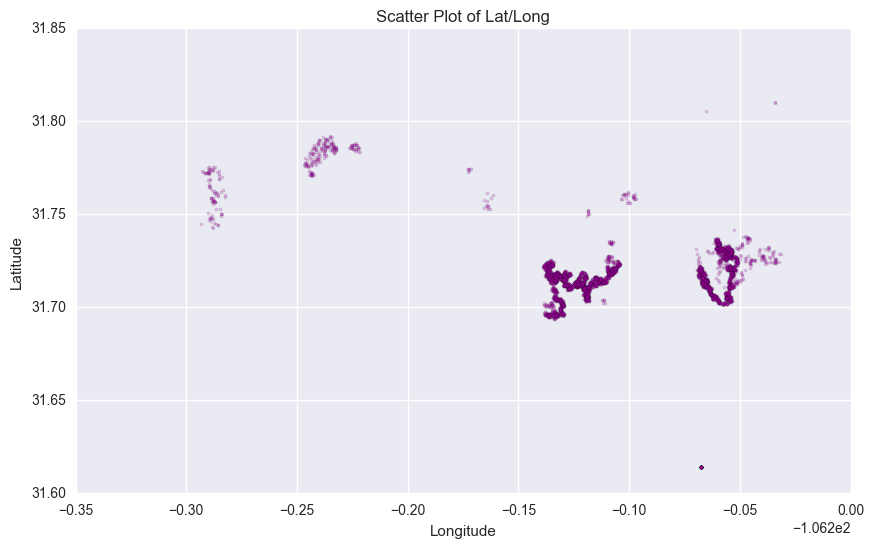

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(df['long'], df['lat'], c='m', edgecolor='k', alpha=.2, s=5)
ax.set_title('Scatter Plot of Lat/Long')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

## K-Means

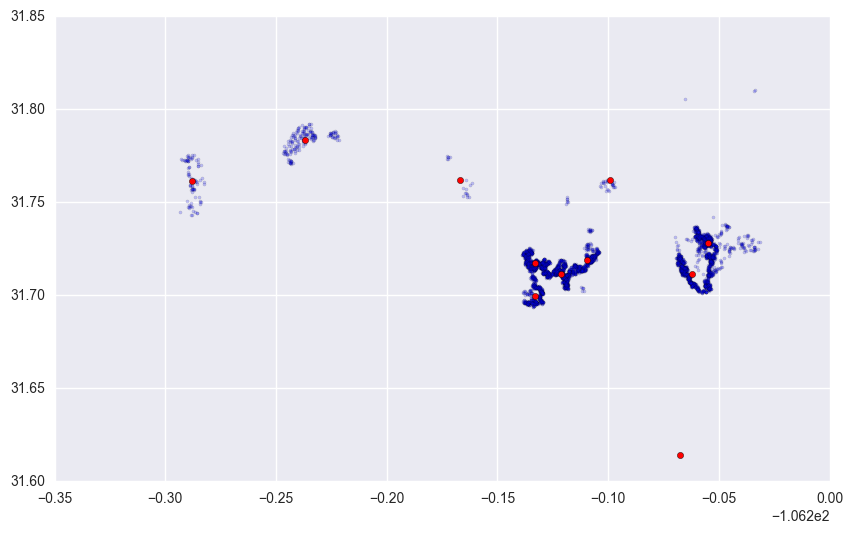

In [8]:
kmeans = KMeans(n_clusters=11).fit(X)

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(df['long'], df['lat'], c='b', edgecolor='k', alpha=.2, s=5)

for y,x in kmeans.cluster_centers_:
    ax.scatter(x,y, c='red')

# DBSCAN

## Determining epsilon, min_pts parameters

In [12]:
def dist2NN(X):
    '''
    Distance to Nearest Neighbor of precomputed distance matrix X
    '''
    return [sorted(row)[1] for row in X]

def pairwise_distance(X):
    #df = pd.DataFrame(X).drop_duplicates()
    return df, squareform(pdist(df, lambda u,v: haversine(u,v)))

def count_elems_lt(array, threshold):
    return len([elem for elem in array if elem <= threshold])

def count_neighbors(X, epsilon):
    '''
    Count neighbors lying in point's epsilon-neighborhood
    '''
    return [count_elems_lt(row, epsilon) for row in X]

### 1. epsilon

In [15]:
import time

start = time.time()
print("hello")
end = time.time()
print(end - start)

hello
8.678436279296875e-05


In [18]:
X_pair = pdist(X, lambda u,v: haversine(u,v, 'km'))

In [16]:
start = time.time()
X_pairwise = squareform(pdist(X, lambda u,v: haversine(u,v, 'km')))
end = time.time()
dist2nn = dist2NN(X_pairwise)

In [17]:
print (end-start)

77.0230119228363


(0, 0.05)

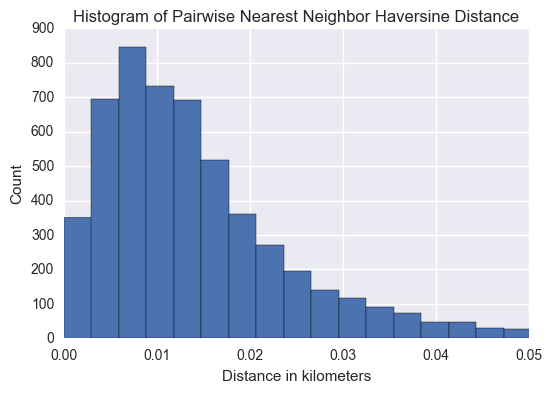

In [11]:
fig, ax = plt.subplots()
ax.hist(dist2nn, bins=1000)
ax.set_title('Histogram of Pairwise Nearest Neighbor Haversine Distance')
ax.set_xlabel('Distance in kilometers')
ax.set_ylabel('Count')
plt.xlim(0, 0.05)
#fig.savefig('viz/pairwise_NN_hist.png')

(0, 0.05)

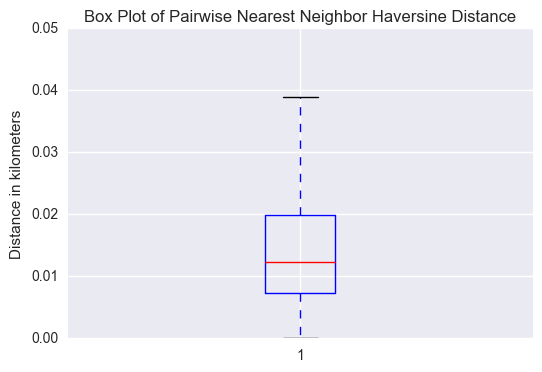

In [13]:
fig, ax = plt.subplots()
ax.boxplot(dist2nn)
ax.set_title('Box Plot of Pairwise Nearest Neighbor Haversine Distance')
ax.set_ylabel('Distance in kilometers')
plt.ylim(0, 0.05)
#fig.savefig('viz/pairwise_NN_boxplot.png')

### 2. min_pts

In [15]:
neighbors_eps = count_neighbors(X_pairwise, 0.2)

/Users/johnmin/src/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


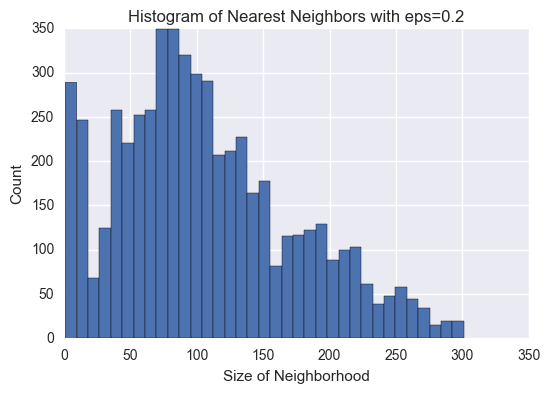

In [16]:
fig, ax = plt.subplots()
ax.hist(neighbors_eps, bins=35)
ax.set_title('Histogram of Nearest Neighbors with eps=0.2')
ax.set_xlabel('Size of Neighborhood')
ax.set_ylabel('Count')
fig.show()
#fig.savefig('viz/NN_eps_0.2_hist.png')

/Users/johnmin/src/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


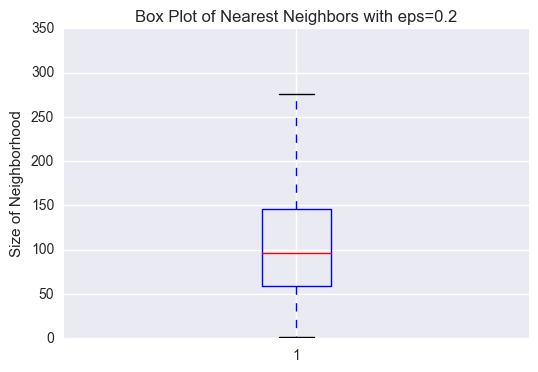

In [18]:
fig, ax = plt.subplots()
ax.boxplot(neighbors_eps)
ax.set_title('Box Plot of Nearest Neighbors with eps=0.2')
ax.set_ylabel('Size of Neighborhood')
fig.show()
#fig.savefig('viz/NN_eps_0.2_box.png')

## Implement sklearn.cluster.DBSCAN

In [20]:
#KM_TO_RADIANS=6371
#eps_search = map(lambda x: x/KM_TO_RADIANS, [])
eps_search = [0.005, 0.01, .015, .020, .025, .03] #distance in km
min_samples_search = [5, 10, 25, 50, 100, 150]

In [ ]:
def dbscan_grid_search(X, eps_search=[0.1], min_samples_search=[10]):
    results = []
    for e,n in itertools.product(eps_search, min_samples_search):
        try:
            db = DBSCAN(eps=e, min_samples=n, algorith='ball_tree', metric='haversine').fit(X)
            labels = db.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            silhouette_coef = metrics.silhouette_score(X, labels)
            calinski_harabaz_idx = metrics.calinski_harabaz_score(X, labels)
            results.append((e,n,n_clusters_,silhouette_coef, calinski_harabaz_idx, db))
        except:
            #results.append((e,n,n_clusters_,None))
            results.append((e,n,n_clusters_,0,0,0)) #put 0 instead of None for result comparison
    return results

def find_best_result(results, metric):
    
    assert (metric in ['silhouette', 'calinski-harabaz']), "metric must be {'silhouette', 'calinski-harabaz'}"
    
    if metric == 'silhouette':
        idx = 3
    if metric == 'calinski-harabaz':
        idx = 4        
    return max(results, key=itemgetter(idx))

In [22]:
dbscan_results = dbscan_grid_search(X, eps_search, min_samples_search)

In [23]:
results_df = pd.DataFrame(dbscan_results)
results_df.columns = ['epsilon', 'min_pts', 'n_clusters', 'silhouette_score', 'calinski-harabaz_idx', 'db_obj']
#results_df.to_csv('results.csv', index=False)

In [24]:
results_df[['epsilon', 'min_pts', 'n_clusters', 'silhouette_score', 'calinski-harabaz_idx']]

,epsilon,min_pts,n_clusters,silhouette_score,calinski-harabaz_idx
0,0.005,5,12,0.415288,8838.212002
1,0.005,10,9,0.576064,10783.070888
2,0.005,25,8,0.715520,7677.094203
3,0.005,50,3,0.708759,3794.465513
4,0.005,100,2,0.718524,4337.422521
5,0.005,150,2,0.717424,4273.086872
6,0.010,5,9,0.689658,11536.681191
7,0.010,10,7,0.732200,14003.485477
8,0.010,25,6,0.738377,16074.913472
9,0.010,50,4,0.762399,8447.786138


In [25]:
#db = DBSCAN(eps=.02, min_samples=25, metric='haversine').fit(X)
best_db = find_best_result(dbscan_results, metric='silhouette')
db = best_db[5]
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.4f"
      % best_db[3])
print("Calinski-Harabaz Index: %0.4f"
      % best_db[4])     

Estimated number of clusters: 5
Silhouette Coefficient: 0.7748
Calinski-Harabaz Index: 17459.6483


/Users/johnmin/src/anaconda3/lib/python3.5/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


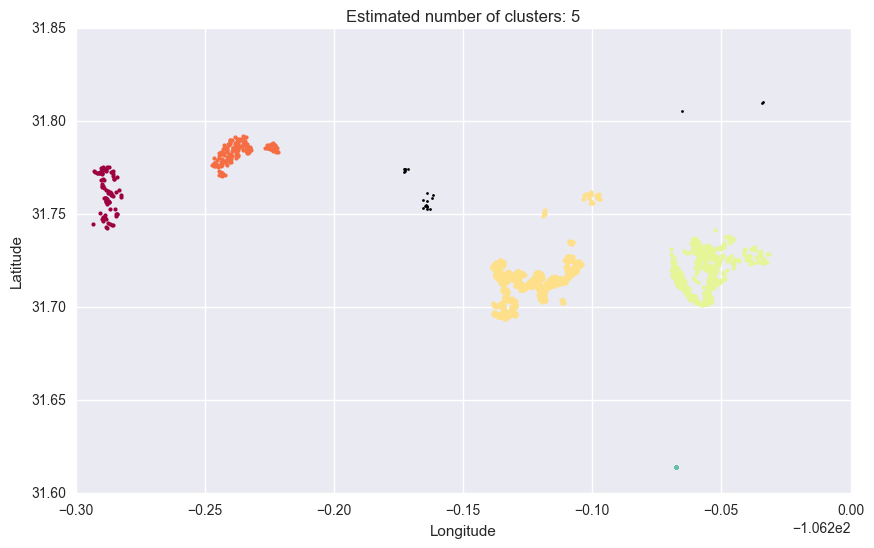

In [26]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=3)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#fig.savefig('viz/dbscan_result.png')

## Find cluster centers

In [30]:
df['cluster'] = labels

In [31]:
def get_center(data, method='mean'):
    '''
    df: pd.DataFrame with lat/long columns
    '''
    df = data[(pd.notnull(data['lat'])) & (pd.notnull(data['long']))] 
    df['lat_rad'] = df['lat'].apply(radians)
    df['long_rad'] = df['long'].apply(radians)

    if method == 'mean':
        # pre-compute trig
        df['lat_cos'] = df['lat_rad'].apply(cos)
        df['lat_sin'] = df['lat_rad'].apply(sin)    
        df['long_cos'] = df['long_rad'].apply(cos)    
        df['long_sin'] = df['long_rad'].apply(sin)
        
        # compute center
        N = len(df)
        x = sum(df['lat_cos'] * df['long_cos'])/N
        y = sum(df['lat_cos'] * df['long_sin'])/N
        z = sum(df['lat_sin'])/N

        long_rad = atan2(y, x)
        hyp = sqrt(x * x + y * y)
        lat_rad = atan2(z, hyp)
        
    elif method == 'median':
        lat_rad = df['lat_rad'].median()
        long_rad = df['long_rad'].median()
    
    # convert back from radians to degrees
    lat = degrees(lat_rad)
    long = degrees(long_rad)
    return (lat, long)

def get_cluster_centers(df, center_type='mean'):        
    centers = {}
    labels = [x for x in df['cluster'].unique() if x >= 0]
    
    cluster_grps = df.groupby('cluster')
    for label in labels:
        cluster_df = cluster_grps.get_group(label)
        center = get_center(cluster_df, center_type)
        centers[label] = center
    return centers

In [32]:
mean_centers = get_cluster_centers(df, 'mean')
median_centers = get_cluster_centers(df, 'median')

In [33]:
mean_centers

{0: (31.761614247329515, -106.48791937044788),
 1: (31.783268572476967, -106.43702728958112),
 2: (31.71314594181163, -106.32482806930082),
 3: (31.719966748920214, -106.25817918102217),
 4: (31.614008000000002, -106.26743)}

In [34]:
median_centers

{0: (31.761507, -106.48811500000001),
 1: (31.7848175, -106.43795),
 2: (31.713848, -106.32708999999998),
 3: (31.720252000000002, -106.25674),
 4: (31.614008000000002, -106.26743)}

### Distance between Median and Mean Cluster Centeres

In [35]:
for i in range(len(mean_centers)):
    print (i, haversine(median_centers[i], mean_centers[i]))

0 0.022013600788890562
1 0.19311645562499774
2 0.2278288633480367
3 0.13981584641076175
4 0.0


### Mean Centers

/Users/johnmin/src/anaconda3/lib/python3.5/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


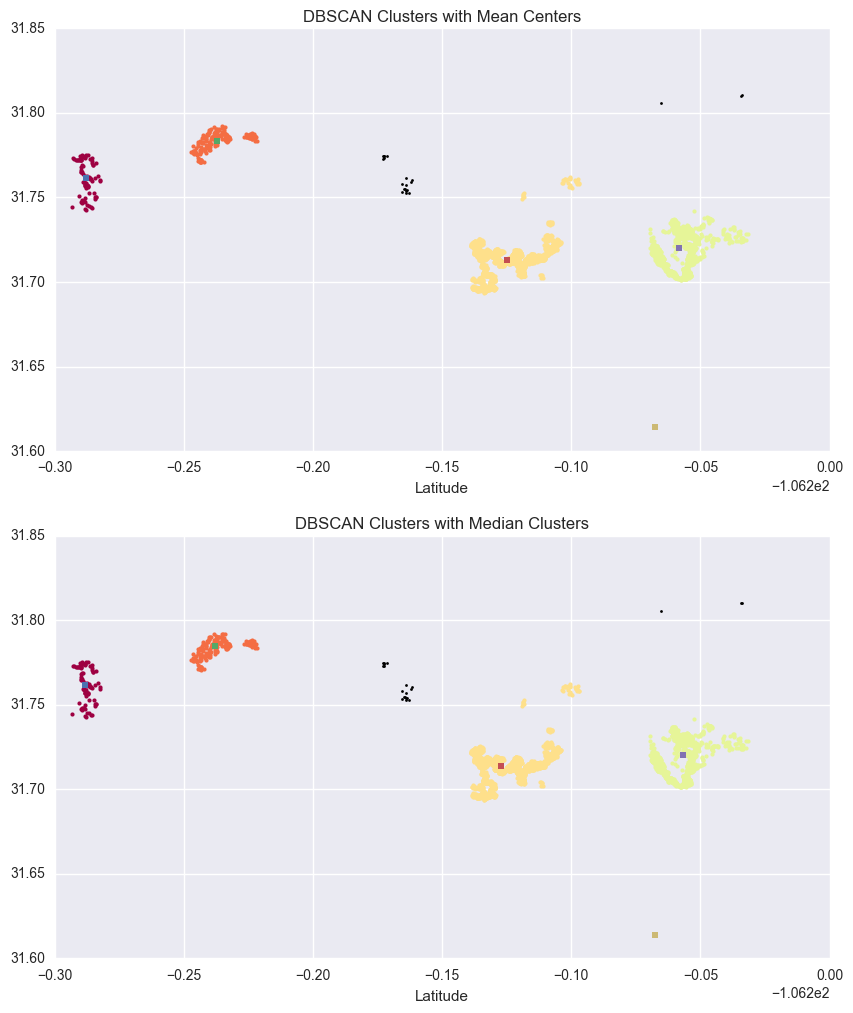

In [36]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(10, 12)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    ax1.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=3)

    xy = X[class_member_mask & ~core_samples_mask]
    ax1.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=2)

for center in mean_centers.values():
    ax1.plot(center[1], center[0], 's', markersize=4)

ax1.set_title('DBSCAN Clusters with Mean Centers')    
ax1.set_xlabel('Longitude')
ax1.set_xlabel('Latitude')    
    
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    ax2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=3)

    xy = X[class_member_mask & ~core_samples_mask]
    ax2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=2)

for center in median_centers.values():
    ax2.plot(center[1], center[0], 's', markersize=4)
    

ax2.set_title('DBSCAN Clusters with Median Clusters')
ax2.set_xlabel('Longitude')
ax2.set_xlabel('Latitude')    
    
    
#plt.title('Clusters with Mean Centers')
#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')
plt.show()

## Choose cluster

### Fixed Time Window

In [37]:
def choose_cluster_fixed_window(data, start_hr=22, end_hr=6):
    if start_hr >= end_hr:
        df = data[(data['hour'] >= start_hr) | (data['hour'] <= end_hr)]    
    else:
        df = data[(data['hour'] >= start_hr) & (data['hour'] <= end_hr)]
    
    cluster = df['cluster'].value_counts().sort_values(ascending=False).index[0]
    return cluster

In [40]:
choose_cluster_fixed_window(df)

3

In [41]:
mean_centers[3]

(31.719966748920214, -106.25817918102217)

In [42]:
median_centers[3]

(31.720252000000002, -106.25674)

/Users/johnmin/src/anaconda3/lib/python3.5/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


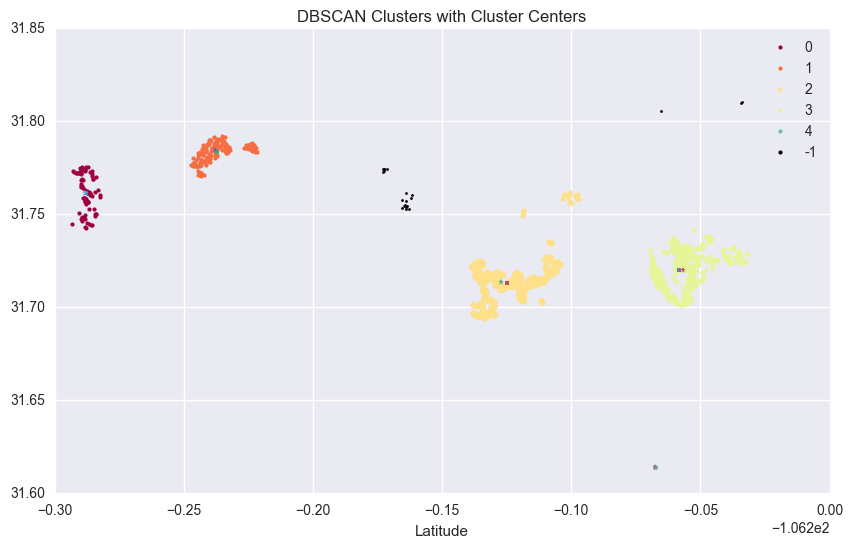

In [43]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
fig, ax = plt.subplots()
fig.set_size_inches(10,6)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    ax.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=3, label=k)

    xy = X[class_member_mask & ~core_samples_mask]
    ax.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=2)

for center in mean_centers.values():
    ax.plot(center[1], center[0], 's', markersize=3)

for center in median_centers.values():
    ax.plot(center[1], center[0], '*', markersize=4.5)

cluster = choose_cluster_fixed_window(df)    
    
MEAN_CENTER = mean_centers[cluster]   
MEDIAN_CENTER = median_centers[cluster]   

#ax.plot(MEAN_CENTER[1], MEAN_CENTER[0], '*', c='m', markersize=10)
ax.plot(MEDIAN_CENTER[1], MEDIAN_CENTER[0], 'x', c='blue', markersize=10)

    
ax.set_title('DBSCAN Clusters with Cluster Centers')    
ax.set_xlabel('Longitude')
ax.set_xlabel('Latitude')
legend = ax.legend()

### Home Cluster

In [44]:
cluster_df = df[df['cluster']==cluster]

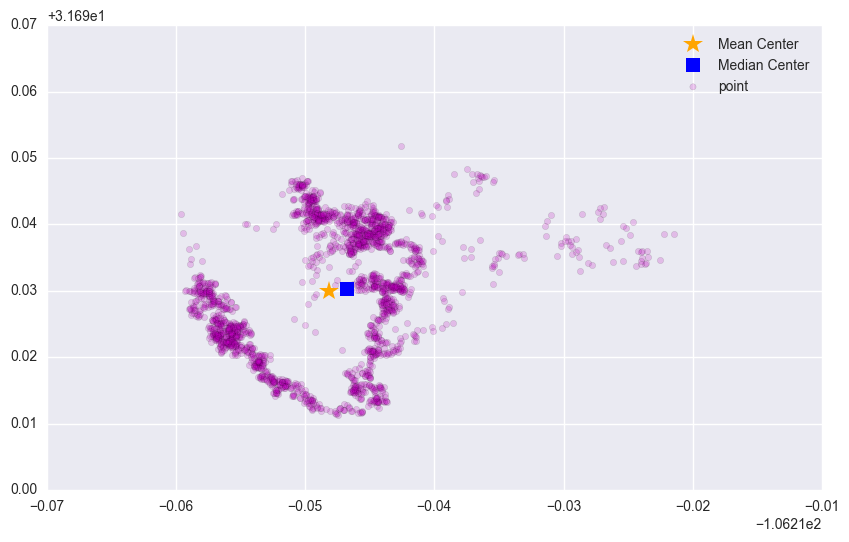

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
ax.scatter(cluster_df['long'], cluster_df['lat'], c='m', alpha=0.2, s=20, label='point')
ax.plot(MEAN_CENTER[1], MEAN_CENTER[0], '*', c='orange', markersize=15, label='Mean Center')
ax.plot(MEDIAN_CENTER[1], MEDIAN_CENTER[0], 's', c='blue', markersize=10, label='Median Center')
ax.legend()
#fig.savefig('viz/cluster_3_center.png')